# Knowledge Injection in RL

RL is commonly used in a full **end-to-end** fashion: given an input representation of the problem, the agent is directly trained to provide a solution, without exploiting prior knowledge of the problem. 
When the problem is hard or has an huge actions space, training the agent is expensive or even impossible. 
A notable example is combinatorial optimization: a wide range of combinatorial optimization problems are NP-hard and the solution search space grows exponentially with the size of the problem. This is the reason why they can be a promising use case to evaluate the impact of knowledge injection in RL.

Recently there has been an increasing interest in combining RL with traditional combinatorial optimization methods. The overall idea is to replace hand-designed heuristics, employed in search algorithms, with RL.
An example is https://ojs.aaai.org/index.php/AAAI/article/view/16484 where RL is used as a value-selection heuristic during variables assignments in the search for the solution of Constraint Satisfaction Problems (CSPs).


## Partial Latin Square

We consider the Partial Latin Square (PLS) completion problem which is a well-known CSP with several practical applications.

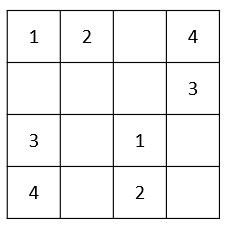

It requires to complete a partially filled $N \times N$ square with all the values in the range $\{ 1,\dots, N \}$ such that no value appears twice on any row or column.

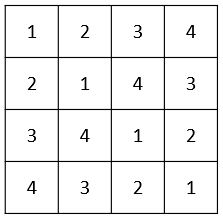

## RL for solving the PLS

We start by training an RL agent to find a solution by filling one cell at time.

We frame the problem as a Markov Decision Process (MDP). An MDP is defined by the tuple $(S, A, R, p, \gamma)$, where $S$ is the set of states, $A$ is the set of actions, $R:S \times A \rightarrow \mathbb{R}$ is the reward function, $p(\cdot | s, a)$ is the probability of leading to a new state by performing action $a$ in state $s$ and $\gamma$ is the discount factor that allows to find a tradeoff between immediate and long-term rewards.

Here the state is the one-hot encoding of the square: if $n$ is the dimension of the PLS, the state $s$ has dimension $n \times n \times n$ where the first dimension represents the row, the second the column and the third the value assigned. An action $a$ consists of assigning a value to a cell (raising a bit in the one-hot encoding representation). The reward is $-1$ for each timestep and $-1000$ if the solution found is infeasible. There may be several viable ways to assign rewards but for one we simply pick this aforementioned.

Let's an example with an agent that performs random actions.

In [1]:
import os
import sys
import inspect

# Move up in the directory
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from rl_utils import PLSEnv, RandomAgent, PLSEnv_partially_filled
from utility import PLSInstance

Create an a simple PLS instance of size $2 \times 2$ and the random agent.

Let's do an episode.

In [2]:
dim = 2
env = PLSEnv(dim=dim)
agent = RandomAgent(num_actions=env.action_space.n, render_actions=True)

In [3]:
done = False

env.reset()
while not done:
    action = agent.act()
    obs, reward, done, info = env.step(action=action)
    env.render()
    
    print(f"feasibile: {info['Feasible']}")
    if info['Solved']:
        print("Solved!")
    
    print('\n' + '-'*100 + '\n')

Row: [2] | Column: [2] | Value: [1]
[[0 0]
 [0 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: [1] | Column: [2] | Value: [1]
[[0 0]
 [0 1]]
feasibile: False

----------------------------------------------------------------------------------------------------



## First task

As a first task we will train an RL agent to solve the PLS of small size (e.g. $5 \times 5$) in a full end-to-end fashion. A good candidate algorithm is Q-learning since the action space is discrete. There are several open source libraries (e.g. stable-baseline, garage, keras-rl, rl-lib, ...); just pick the one you prefer (or if you like, you can implement Q-learning from scratch but it is not required).

In [4]:
# Imports

# General utilities
from pathlib import Path
import time

# Environment utilities
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor

# Neural model definition
import numpy as np
import torch as th
from stable_baselines3 import DQN

# Visualizations
import pandas as pd
import matplotlib.pyplot as plt

# Model evaluation
from stable_baselines3.common.evaluation import evaluate_policy

In [5]:
# Constants definition
IMG_DPI = 200
N_TRAINING_TIMESTEPS_ETE = 100000
N_TRAINING_TIMESTEPS_KINJ = 10000

# Create directoy to store plots
PLOTS_DIR_NAME = "notebook-plots"
Path(os.path.join(os.getcwd(), PLOTS_DIR_NAME)).mkdir(parents=True, exist_ok=True)

In [6]:
# Pytorch cuda check
print(th.cuda.is_available())
print(th.cuda.device_count())
print(th.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 2060


### Utility functions definition

In [7]:
def make_pls_env(dim):
    # Environment definition
    # Latin square will have dimension dim x dim
    # Construct the environment
    env = PLSEnv_partially_filled(dim=dim)
    # Check the correctness of the environment
    check_env(env)
    # Wrap the environment in a monitor to track training progress
    env = Monitor(env)
    
    return env

In [8]:
def make_DQN_model(env, policy="MlpPolicy", less_time=False):
    # DQN network architecture
    policy_kwargs = dict(activation_fn=th.nn.ReLU,
                         net_arch=[32, 32],
                         normalize_images=False)
    
    if less_time == False:
        # DQN model definition
        model = DQN(policy, env, policy_kwargs=policy_kwargs,
                    learning_rate=0.001,
                    batch_size=512,
                    gamma=0.95,
                    exploration_initial_eps=1.0,
                    exploration_final_eps=0.05,
                    exploration_fraction=0.35,
                    buffer_size=10000,
                    learning_starts=10000,
                    verbose=1)
    else:
        # DQN model definition
        model = DQN(policy, env, policy_kwargs=policy_kwargs,
                    learning_rate=0.001,
                    batch_size=256,
                    gamma=0.95,
                    exploration_initial_eps=1.0,
                    exploration_final_eps=0.05,
                    exploration_fraction=0.1,
                    #exploration_fraction=0, # test
                    buffer_size=512,
                    learning_starts=512,
                    #learning_starts=1, # test
                    verbose=1)
    
    #print("")
    #print("Model Architecture:")
    #print(model.policy)
    
    return model

In [9]:
# Apply a smooting average to smooth the time series.
# The function returns both the smoothed time series and the original one, converted into pandas dataframe objects.
def smooth_time_series(points_list, windows_size=3, remove_start_end_nans=True):
    points_list_pd = pd.DataFrame(points_list)
    smoothed_list_pd = points_list_pd.rolling(windows_size, center=True).mean() # Apply moving average
    if remove_start_end_nans:
        return smoothed_list_pd[int(windows_size/2) : -int(windows_size/2)], points_list_pd[int(windows_size/2) : -int(windows_size/2)]
    else:
        return smoothed_list_pd, points_list_pd

In [10]:
# Obtain the output q_values from the model given an observation and the environment
def get_q_values(model, obs, env):
    cuda0 = th.device('cuda:0')
    obs = th.tensor(obs).to(cuda0)
    obs = obs.reshape((-1,) + env.observation_space.shape)
    return model.policy.q_net(obs)

In [11]:
# Play a game

def play_single_game(agent, env):
    dim = env.dim
    done = False
    n_actions_performed = 0
    obs = env.reset()
    while not done:
        # Decide action
        if isinstance(agent, RandomAgent):
            action = agent.act(obs)
        else:
            action, _states = agent.predict(obs, deterministic=True)
        
        # Print selected action
        #print(f"action number: {action}")
        row, col, val = np.unravel_index(action, shape=(dim, dim, dim))
        print(f'Row: {row+1} | Column: {col+1} | Value: {val+1}')

        # Perform action
        obs, reward, done, info = env.step(action=action)
        env.render()
        n_actions_performed = n_actions_performed + 1

        print(f"feasibile: {info['Feasible']}")
        if info['Solved']:
            print("Solved!")

        print('\n' + '-'*100 + '\n')

    print(f"Number of actions performed: {n_actions_performed}")

In [12]:
# Model/Agent Evaluation

def evaluate_agent(agent, dim):
    perc_to_evaluate = [0.25, 0.50, 0.75]
    for perc in perc_to_evaluate:
        print(f"MODEL EVALUATION WITH LATIN SQUARES {perc*100}% FILLED")
        env = PLSEnv_partially_filled(dim=dim, perc_to_fill=perc)
        env = Monitor(env)
        n_eval_episodes = 100
        lengths_list = []
        rewards_list = []
        n_pls_solved = 0

        for episode in range(n_eval_episodes):
            obs = env.reset()
            done = False
            episode_reward = 0
            episode_length = 0
            while not done:
                if isinstance(agent, RandomAgent):
                    action = agent.act(obs)
                else:
                    action, _states = agent.predict(obs, deterministic=True)
                obs, reward, done, info = env.step(action=action)
                episode_reward = episode_reward + reward
                episode_length = episode_length + 1
            
            if info["Solved"]:
                n_pls_solved = n_pls_solved + 1
            rewards_list.append(episode_reward)
            lengths_list.append(episode_length)

        print()
        print(f"Latin squares solved: {(n_pls_solved/n_eval_episodes)*100}%")
        print()
        print(f"Mean reward over {n_eval_episodes} episodes: {np.mean(rewards_list)}")
        print(f"Mean reward std {np.std(rewards_list)}")
        print()
        print(f"Mean episode length over {n_eval_episodes} episodes: {np.mean(lengths_list)}")
        print(f"Mean episode length std {np.std(lengths_list)}")
        print()
        print()

### RL End-to-end on 3x3 latin square

In [13]:
# Environment definition
dim = 3
env = make_pls_env(dim=dim)

In [14]:
# Print some example grids
for i in range(0,3):
    env.reset()
    env.render()
    print()

[[3 0 2]
 [0 3 1]
 [1 0 3]]

[[0 0 0]
 [0 0 1]
 [1 0 0]]

[[1 2 0]
 [0 1 2]
 [2 3 0]]



In [15]:
# DQN model definition
model = make_DQN_model(env)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [16]:
# Model Training

start_time = time.time()
model.learn(total_timesteps=N_TRAINING_TIMESTEPS_ETE, log_interval=10000)
print(f"Training time: {(time.time()-start_time)/60} minutes")

#model.save("dqn_model")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.24     |
|    ep_rew_mean      | -0.86    |
|    exploration_rate | 0.582    |
| time/               |          |
|    episodes         | 10000    |
|    fps              | 242      |
|    time_elapsed     | 63       |
|    total_timesteps  | 15397    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0514   |
|    n_updates        | 1349     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.9      |
|    ep_rew_mean      | 0.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20000    |
|    fps              | 256      |
|    time_elapsed     | 192      |
|    total_timesteps  | 49448    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0135   |
|    n_updates      

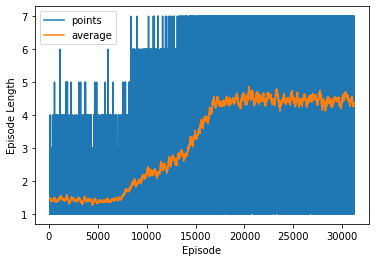

In [17]:
# Plot episodes lentghs during training
sl, pl = smooth_time_series(env.get_episode_lengths(), windows_size=200)
#env.get_episode_rewards()
#env.get_episode_lengths()
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR_NAME, "dqn_length_3x3.png"), dpi=IMG_DPI)
plt.show()

In [18]:
# Play a game
play_single_game(model, env)

Row: 3 | Column: 3 | Value: 1
[[3 0 2]
 [0 0 0]
 [0 0 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 3 | Column: 1 | Value: 2
[[3 0 2]
 [0 0 0]
 [2 0 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 2 | Column: 3 | Value: 3
[[3 0 2]
 [0 0 3]
 [2 0 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 3 | Column: 2 | Value: 3
[[3 0 2]
 [0 0 3]
 [2 3 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 2 | Column: 1 | Value: 1
[[3 0 2]
 [1 0 3]
 [2 3 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 2 | Value: 1
[[3 1 2]
 [1 0 3]
 [2 3 1]]
feasibile: True

----------------------------------------

In [19]:
# Model Evaluation
evaluate_agent(model, dim)

MODEL EVALUATION WITH LATIN SQUARES 25.0% FILLED

Latin squares solved: 79.0%

Mean reward over 100 episodes: 0.58
Mean reward std 0.8146164741766521

Mean episode length over 100 episodes: 6.7
Mean episode length std 0.7000000000000001


MODEL EVALUATION WITH LATIN SQUARES 50.0% FILLED

Latin squares solved: 94.0%

Mean reward over 100 episodes: 0.88
Mean reward std 0.4749736834815167

Mean episode length over 100 episodes: 4.9
Mean episode length std 0.4358898943540674


MODEL EVALUATION WITH LATIN SQUARES 75.0% FILLED

Latin squares solved: 100.0%

Mean reward over 100 episodes: 1.0
Mean reward std 0.0

Mean episode length over 100 episodes: 3.0
Mean episode length std 0.0




### RL End-to-end on 5x5 latin square

In [20]:
# Environment definition
dim = 5
env = make_pls_env(dim=dim)

In [21]:
# Print some example grids
for i in range(0,3):
    env.reset()
    env.render()
    print()

[[0 0 0 0 0]
 [5 3 1 0 0]
 [0 0 0 0 0]
 [0 0 5 0 0]
 [3 4 0 0 0]]

[[2 4 5 1 0]
 [4 0 2 5 0]
 [0 1 3 2 0]
 [0 5 1 4 0]
 [1 2 4 3 5]]

[[0 0 5 2 4]
 [0 0 2 0 1]
 [2 1 0 0 0]
 [0 0 1 5 0]
 [0 4 3 0 2]]



In [22]:
# DQN model definition
model = make_DQN_model(env)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [23]:
# Model Training

start_time = time.time()
model.learn(total_timesteps=N_TRAINING_TIMESTEPS_ETE, log_interval=10000)
print(f"Training time: {(time.time()-start_time)/60} minutes")

#model.save("dqn_model")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.52     |
|    ep_rew_mean      | -1       |
|    exploration_rate | 0.625    |
| time/               |          |
|    episodes         | 10000    |
|    fps              | 67       |
|    time_elapsed     | 204      |
|    total_timesteps  | 13817    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0739   |
|    n_updates        | 954      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | -1       |
|    exploration_rate | 0.157    |
| time/               |          |
|    episodes         | 20000    |
|    fps              | 68       |
|    time_elapsed     | 452      |
|    total_timesteps  | 31075    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.028    |
|    n_updates      

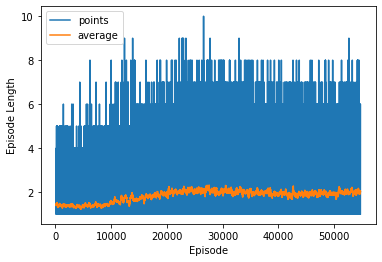

In [24]:
# Plot episodes lentghs during training
sl, pl = smooth_time_series(env.get_episode_lengths(), windows_size=200)
#env.get_episode_rewards()
#env.get_episode_lengths()
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR_NAME, "dqn_length_5x5.png"), dpi=IMG_DPI)
plt.show()

In [25]:
# Play a game
play_single_game(model, env)

Row: 1 | Column: 3 | Value: 1
[[1 2 0 4 0]
 [2 3 0 0 5]
 [0 0 3 0 1]
 [0 0 2 3 0]
 [3 4 0 0 0]]
feasibile: False

----------------------------------------------------------------------------------------------------

Number of actions performed: 1


In [26]:
# Model Evaluation
evaluate_agent(model, dim)

MODEL EVALUATION WITH LATIN SQUARES 25.0% FILLED

Latin squares solved: 0.0%

Mean reward over 100 episodes: -1.0
Mean reward std 0.0

Mean episode length over 100 episodes: 3.18
Mean episode length std 1.4239382009062052


MODEL EVALUATION WITH LATIN SQUARES 50.0% FILLED

Latin squares solved: 0.0%

Mean reward over 100 episodes: -1.0
Mean reward std 0.0

Mean episode length over 100 episodes: 1.66
Mean episode length std 0.8027452896155791


MODEL EVALUATION WITH LATIN SQUARES 75.0% FILLED

Latin squares solved: 0.0%

Mean reward over 100 episodes: -1.0
Mean reward std 0.0

Mean episode length over 100 episodes: 1.2
Mean episode length std 0.447213595499958




## Second task

As a second task, we will inject knowledge about the problem constraint in the RL algorithm.

In particular, we will use the **Forward checking** algorithm to prune provably infeasible actions from their domain.

### Forward checking 

When a variable is assigned, we remove the non-consistent values, according to the constraints, from the domain of the not assigned variables.

Let's see an example.

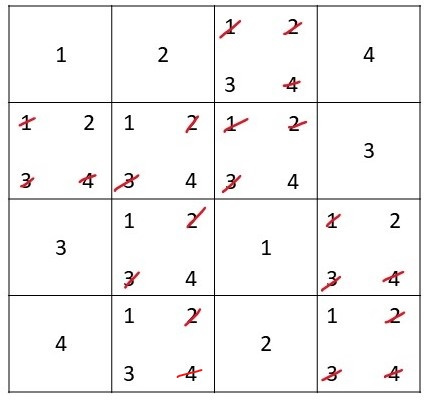

In the picture above we see a partial solution and the domains of the not assigned variables.

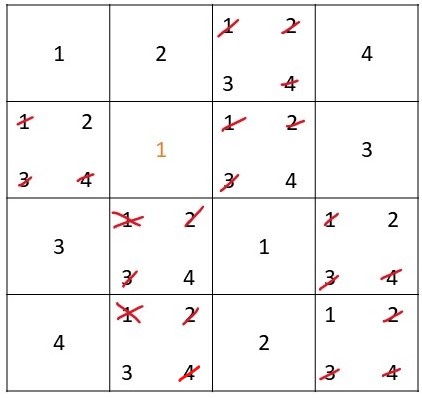

Assuming to make the assignments highlighted in orange, the forward checking algorithm prunes the variables domains as depicted in the figure above (the double-crossed values).

An (very inefficient) implementation can be found in the `_forward_checking` method of the `PLSInstance` class. 

Your task is to modify the RL algorithm preventing the agent to perform provably infeasible actions.

### Hint

If you are using `stable-baseline3` and DQN as the RL algorithm, you can modify the `_predict` method of the `QNetwork` class (https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/dqn/policies.py) setting the Q-values of infeasible actions to minus infinity. 

### Definition of random agent with forward checking

In [27]:
class RandomAgentWithForwardChecking(RandomAgent):
    def act(self, obs):
        """
        Choose an action.
        :return: int; the chosen action.
        """
        dim = self._dim
        obs_matrix = np.reshape(obs, (dim, dim, dim))
        # Use PLSInstance to perform forward checking and obtain the domains of each latin square cell.
        pls_i = PLSInstance(n=dim)
        pls_i.set_square(obs_matrix, forward=True)
        # Reshape the domains from a 3D matrix to a one-dimensional vector
        domains = np.reshape(pls_i.domains, (-1))
        # check if there is at least one possible action
        if 0 in domains:
            # Make a list of all actions that have domain equal to zero
            possible_actions = np.arange(self._num_actions)[domains==0]
            # Select a random action
            action = np.random.choice(possible_actions)
        else:
            # It will fail
            action = 0
        if self._render_actions:
            row, col, val = np.unravel_index(action, shape=(self._dim, self._dim, self._dim))
            print(f'Row: {row+1} | Column: {col+1} | Value: {val+1}')
        
        return action

### Random agent with forward checking on 3x3 latin square

In [28]:
# Environment definition
dim = 3
env = make_pls_env(dim=dim)

In [29]:
agent = RandomAgentWithForwardChecking(num_actions=env.action_space.n, render_actions=False)

In [30]:
# Play a single game
play_single_game(agent, env)

Row: 2 | Column: 2 | Value: 2
[[0 0 0]
 [0 2 0]
 [2 1 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 3 | Value: 3
[[0 0 3]
 [0 2 0]
 [2 1 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 2 | Column: 3 | Value: 1
[[0 0 3]
 [0 2 1]
 [2 1 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 2 | Column: 1 | Value: 3
[[0 0 3]
 [3 2 1]
 [2 1 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 1 | Value: 1
[[1 0 3]
 [3 2 1]
 [2 1 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 1 | Value: 1
[[1 0 3]
 [3 2 1]
 [2 1 0]]
feasibile: False

---------------------------------------

In [32]:
# Model Evaluation
evaluate_agent(agent, dim)

MODEL EVALUATION WITH LATIN SQUARES 25.0% FILLED

Latin squares solved: 27.0%

Mean reward over 100 episodes: -0.46
Mean reward std 0.8879189152169246

Mean episode length over 100 episodes: 6.21
Mean episode length std 0.5881326381013046


MODEL EVALUATION WITH LATIN SQUARES 50.0% FILLED

Latin squares solved: 57.99999999999999%

Mean reward over 100 episodes: 0.16
Mean reward std 0.9871170143402452

Mean episode length over 100 episodes: 4.58
Mean episode length std 0.49355850717012273


MODEL EVALUATION WITH LATIN SQUARES 75.0% FILLED

Latin squares solved: 96.0%

Mean reward over 100 episodes: 0.92
Mean reward std 0.39191835884530857

Mean episode length over 100 episodes: 2.96
Mean episode length std 0.19595917942265428




### Random agent with forward checking on 5x5 latin square

In [33]:
# Environment definition
dim = 5
env = make_pls_env(dim=dim)

In [34]:
agent = RandomAgentWithForwardChecking(num_actions=env.action_space.n, render_actions=False)

In [35]:
# Play a single game
play_single_game(agent, env)

Row: 5 | Column: 2 | Value: 1
[[0 0 1 3 0]
 [2 4 0 5 0]
 [1 3 2 4 5]
 [5 2 4 1 3]
 [0 1 5 2 4]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 5 | Column: 1 | Value: 3
[[0 0 1 3 0]
 [2 4 0 5 0]
 [1 3 2 4 5]
 [5 2 4 1 3]
 [3 1 5 2 4]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 2 | Column: 5 | Value: 1
[[0 0 1 3 0]
 [2 4 0 5 1]
 [1 3 2 4 5]
 [5 2 4 1 3]
 [3 1 5 2 4]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 1 | Value: 4
[[4 0 1 3 0]
 [2 4 0 5 1]
 [1 3 2 4 5]
 [5 2 4 1 3]
 [3 1 5 2 4]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 5 | Value: 2
[[4 0 1 3 2]
 [2 4 0 5 1]
 [1 3 2 4 5]
 [5 2 4 1 3]
 [3 1 5 2 4]]
feasibile: True

---------------------------

In [36]:
# Model Evaluation
evaluate_agent(agent, dim)

MODEL EVALUATION WITH LATIN SQUARES 25.0% FILLED

Latin squares solved: 1.0%

Mean reward over 100 episodes: -0.98
Mean reward std 0.19899748742132398

Mean episode length over 100 episodes: 16.2
Mean episode length std 1.2806248474865696


MODEL EVALUATION WITH LATIN SQUARES 50.0% FILLED

Latin squares solved: 13.0%

Mean reward over 100 episodes: -0.74
Mean reward std 0.6726068688320095

Mean episode length over 100 episodes: 11.23
Mean episode length std 1.1563304026099113


MODEL EVALUATION WITH LATIN SQUARES 75.0% FILLED

Latin squares solved: 70.0%

Mean reward over 100 episodes: 0.4
Mean reward std 0.9165151389911679

Mean episode length over 100 episodes: 6.66
Mean episode length std 0.5517245689653488




### Definition of DQN models with knowledge injection

In [37]:
# Imports
from stable_baselines3.dqn.policies import QNetwork, DQNPolicy

#### DQN with knowledge injection only during evaluation

In [38]:
# Override some methods of the class QNetwork used by the DQN model in order to set to a negative value the q-values of
# actions that cannot lead to a solution after performing a forward checking

# Two possibile methods to override:
# Override _predict ---> Knowledge injection only during evaluation
# Override forward ---> Knowledge injection also during training

class QNetwork_K_Inj_E(QNetwork):
    def _predict(self, observation: th.Tensor, deterministic: bool = True) -> th.Tensor:
        # Compute the q-values using the QNetwork
        q_values = self(observation)
        # Obtain the dimension of the partial latin square and convert the observation to a matrix of shape (dim, dim, dim)
        dim = int(np.cbrt(observation.shape[1]))
        obs_matrix = th.reshape(observation, (dim, dim, dim))
        # Use PLSInstance to perform forward checking and obtain the domains of each latin square cell.
        pls_i = PLSInstance(n=dim)
        pls_i.set_square(obs_matrix.cpu().numpy(), forward=True)
        # Reshape the domains from a 3D matrix to a one-dimensional vector, the same shape of
        # the q-values produced by the QNetwork.
        domains = np.reshape(pls_i.domains, (-1))
        # For each q-value associated to a specific action (x, y, value), set it to a big negative number if
        # its associated domain value is equal to 1, which means that the action would certainly lead to a failure.
        q_values[0][domains==1] = -10000
        
        del pls_i
        
        # Greedy action using the new q-values
        action = q_values.argmax(dim=1).reshape(-1)
        return action

    
# Override the make_q_net method of the DQN policy used by the DQN model to make it use the new DQN network with
# knowledge injection.

class DQNPolicy_K_Inj_E(DQNPolicy):
    def make_q_net(self) -> DQNPolicy:
        # Make sure we always have separate networks for features extractors etc
        net_args = self._update_features_extractor(self.net_args, features_extractor=None)
        return QNetwork_K_Inj_E(**net_args).to(self.device)

#### DQN with knowledge injection during both training and evaluation

In [39]:
# Override some methods of the class QNetwork used by the DQN model in order to set to a negative value the q-values of
# actions that cannot lead to a solution after performing a forward checking

# Two possibile methods to override:
# Override _predict ---> Knowledge injection only during evaluation
# Override forward ---> Knowledge injection also during training

class QNetwork_K_Inj_ET(QNetwork):
    
    def forward(self, obs: th.Tensor) -> th.Tensor:
        """
        Predict the q-values.
        :param obs: Observation
        :return: The estimated Q-Value for each action.
        """
        #start_time = time.time()
        # Compute the q-values using the QNetwork
        q_values = self.q_net(self.extract_features(obs))
        # Obtain the dimension of the partial latin square
        dim = int(np.cbrt(obs.shape[1]))
        # For each observation in the training batch:
        for i in range(obs.shape[0]):
            # Convert the observation to a matrix of shape (dim, dim, dim)
            obs_matrix = th.reshape(obs[i], (dim, dim, dim))
            # Use PLSInstance to perform forward checking and obtain the domains of each latin square cell.
            pls_i = PLSInstance(n=dim)
            pls_i.set_square(obs_matrix.cpu().numpy(), forward=True)
            # Reshape the domains from a 3D matrix to a one-dimensional vector, the same shape of
            # the q-values produced by the QNetwork.
            domains = np.reshape(pls_i.domains, (-1))
            # For each q-value associated to a specific action (x, y, value), set it to a big negative number if
            # its associated domain value is equal to 1, which means that the action would certainly lead to a failure.
            q_values[i][domains==1] = -10000

            del pls_i
        
        #print(f"Cycle time: {(time.time()-start_time)} seconds")
        return q_values

    
# Override the make_q_net method of the DQN policy used by the DQN model to make it use the new DQN network with
# knowledge injection.

class DQNPolicy_K_Inj_ET(DQNPolicy):
    def make_q_net(self) -> DQNPolicy:
        # Make sure we always have separate networks for features extractors etc
        net_args = self._update_features_extractor(self.net_args, features_extractor=None)
        return QNetwork_K_Inj_ET(**net_args).to(self.device)

### RL with knowledge injection (evaluation only) on 3x3 latin square

In [40]:
# Environment definition
dim = 3
env = make_pls_env(dim=dim)

In [41]:
# DQN model definition
model = make_DQN_model(env, policy=DQNPolicy_K_Inj_E)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [42]:
# Model Training

start_time = time.time()
model.learn(total_timesteps=N_TRAINING_TIMESTEPS_ETE, log_interval=10000)
print(f"Training time: {(time.time()-start_time)/60} minutes")

#model.save("dqn_model")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | -0.96    |
|    exploration_rate | 0.577    |
| time/               |          |
|    episodes         | 10000    |
|    fps              | 223      |
|    time_elapsed     | 69       |
|    total_timesteps  | 15585    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.041    |
|    n_updates        | 1396     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.36     |
|    ep_rew_mean      | 0.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20000    |
|    fps              | 219      |
|    time_elapsed     | 226      |
|    total_timesteps  | 49740    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00731  |
|    n_updates      

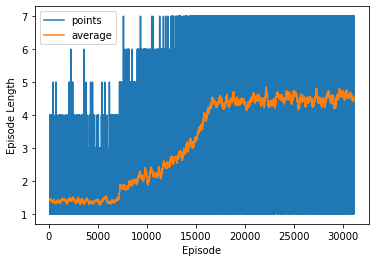

In [43]:
# Plot episodes lentghs during training
sl, pl = smooth_time_series(env.get_episode_lengths(), windows_size=200)
#env.get_episode_rewards()
#env.get_episode_lengths()
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR_NAME, "dqn_length_3x3_K_Inj_E.png"), dpi=IMG_DPI)
plt.show()

In [44]:
# Play a game
play_single_game(model, env)

Row: 2 | Column: 2 | Value: 2
[[0 0 2]
 [0 2 3]
 [0 0 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 1 | Value: 3
[[3 0 2]
 [0 2 3]
 [0 0 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 2 | Value: 1
[[3 1 2]
 [0 2 3]
 [0 0 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 3 | Column: 2 | Value: 3
[[3 1 2]
 [0 2 3]
 [0 3 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 2 | Column: 1 | Value: 1
[[3 1 2]
 [1 2 3]
 [0 3 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 3 | Column: 1 | Value: 2
[[3 1 2]
 [1 2 3]
 [2 3 0]]
feasibile: True

----------------------------------------

In [45]:
# Model Evaluation
evaluate_agent(model, dim)

MODEL EVALUATION WITH LATIN SQUARES 25.0% FILLED

Latin squares solved: 83.0%

Mean reward over 100 episodes: 0.66
Mean reward std 0.751265598839718

Mean episode length over 100 episodes: 6.83
Mean episode length std 0.375632799419859


MODEL EVALUATION WITH LATIN SQUARES 50.0% FILLED

Latin squares solved: 89.0%

Mean reward over 100 episodes: 0.78
Mean reward std 0.6257795138864807

Mean episode length over 100 episodes: 4.89
Mean episode length std 0.31288975694324034


MODEL EVALUATION WITH LATIN SQUARES 75.0% FILLED

Latin squares solved: 100.0%

Mean reward over 100 episodes: 1.0
Mean reward std 0.0

Mean episode length over 100 episodes: 3.0
Mean episode length std 0.0




### RL with knowledge injection (evaluation only) on 5x5 latin square

In [46]:
# Environment definition
dim = 5
env = make_pls_env(dim=dim)

In [47]:
# DQN model definition
model = make_DQN_model(env, policy=DQNPolicy_K_Inj_E)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [48]:
# Model Training

start_time = time.time()
model.learn(total_timesteps=N_TRAINING_TIMESTEPS_ETE, log_interval=10000)
print(f"Training time: {(time.time()-start_time)/60} minutes")

#model.save("dqn_model")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | -1       |
|    exploration_rate | 0.578    |
| time/               |          |
|    episodes         | 10000    |
|    fps              | 65       |
|    time_elapsed     | 238      |
|    total_timesteps  | 15549    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0543   |
|    n_updates        | 1387     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.8      |
|    ep_rew_mean      | -0.58    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20000    |
|    fps              | 116      |
|    time_elapsed     | 670      |
|    total_timesteps  | 77849    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.208    |
|    n_updates      

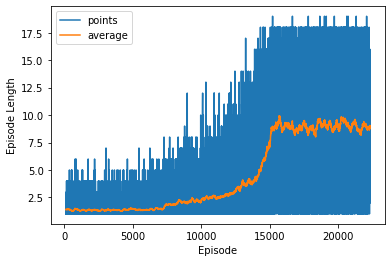

In [49]:
# Plot episodes lentghs during training
sl, pl = smooth_time_series(env.get_episode_lengths(), windows_size=200)
#env.get_episode_rewards()
#env.get_episode_lengths()
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR_NAME, "dqn_length_5x5_K_Inj_E.png"), dpi=IMG_DPI)
plt.show()

In [50]:
# Play a game
play_single_game(model, env)

Row: 5 | Column: 3 | Value: 5
[[0 3 4 0 5]
 [5 0 2 3 4]
 [0 2 3 5 1]
 [3 5 1 4 2]
 [0 0 5 2 3]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 4 | Value: 1
[[0 3 4 1 5]
 [5 0 2 3 4]
 [0 2 3 5 1]
 [3 5 1 4 2]
 [0 0 5 2 3]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 3 | Column: 1 | Value: 4
[[0 3 4 1 5]
 [5 0 2 3 4]
 [4 2 3 5 1]
 [3 5 1 4 2]
 [0 0 5 2 3]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 5 | Column: 2 | Value: 4
[[0 3 4 1 5]
 [5 0 2 3 4]
 [4 2 3 5 1]
 [3 5 1 4 2]
 [0 4 5 2 3]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 5 | Column: 1 | Value: 1
[[0 3 4 1 5]
 [5 0 2 3 4]
 [4 2 3 5 1]
 [3 5 1 4 2]
 [1 4 5 2 3]]
feasibile: True

---------------------------

In [51]:
# Model Evaluation
evaluate_agent(model, dim)

MODEL EVALUATION WITH LATIN SQUARES 25.0% FILLED

Latin squares solved: 0.0%

Mean reward over 100 episodes: -1.0
Mean reward std 0.0

Mean episode length over 100 episodes: 16.03
Mean episode length std 1.1700854669638452


MODEL EVALUATION WITH LATIN SQUARES 50.0% FILLED

Latin squares solved: 4.0%

Mean reward over 100 episodes: -0.92
Mean reward std 0.39191835884530846

Mean episode length over 100 episodes: 11.1
Mean episode length std 1.0440306508910548


MODEL EVALUATION WITH LATIN SQUARES 75.0% FILLED

Latin squares solved: 70.0%

Mean reward over 100 episodes: 0.4
Mean reward std 0.9165151389911679

Mean episode length over 100 episodes: 6.63
Mean episode length std 0.6269768735766894




### RL with knowledge injection (train+evaluation) on 3x3 latin square

In [52]:
# Environment definition
dim = 3
env = make_pls_env(dim=dim)

In [53]:
# DQN model definition
model = make_DQN_model(env, policy=DQNPolicy_K_Inj_ET, less_time=True)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [54]:
# Model Training

start_time = time.time()
model.learn(total_timesteps=N_TRAINING_TIMESTEPS_KINJ, log_interval=1000)
print(f"Training time: {(time.time()-start_time)/60} minutes")

#model.save("dqn_model")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.32     |
|    ep_rew_mean      | -0.12    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 17       |
|    time_elapsed     | 173      |
|    total_timesteps  | 3044     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.24e+03 |
|    n_updates        | 632      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 0.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 15       |
|    time_elapsed     | 464      |
|    total_timesteps  | 7312     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.91e+03 |
|    n_updates      

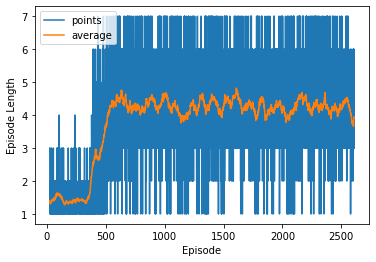

In [55]:
# Plot episodes lentghs during training
sl, pl = smooth_time_series(env.get_episode_lengths(), windows_size=50)
#env.get_episode_rewards()
#env.get_episode_lengths()
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR_NAME, "dqn_length_3x3_K_Inj_ET.png"), dpi=IMG_DPI)
plt.show()

In [56]:
# Play a game
play_single_game(model, env)

Row: 2 | Column: 2 | Value: 2
[[0 1 0]
 [0 2 0]
 [2 3 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 2 | Column: 3 | Value: 3
[[0 1 0]
 [0 2 3]
 [2 3 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 2 | Column: 1 | Value: 1
[[0 1 0]
 [1 2 3]
 [2 3 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 1 | Value: 3
[[3 1 0]
 [1 2 3]
 [2 3 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 3 | Value: 2
[[3 1 2]
 [1 2 3]
 [2 3 1]]
feasibile: True
Solved!

----------------------------------------------------------------------------------------------------

Number of actions performed: 5


In [57]:
# Model Evaluation
evaluate_agent(model, dim)

MODEL EVALUATION WITH LATIN SQUARES 25.0% FILLED

Latin squares solved: 32.0%

Mean reward over 100 episodes: -0.36
Mean reward std 0.9329523031752479

Mean episode length over 100 episodes: 6.3
Mean episode length std 0.5196152422706632


MODEL EVALUATION WITH LATIN SQUARES 50.0% FILLED

Latin squares solved: 71.0%

Mean reward over 100 episodes: 0.42
Mean reward std 0.9075241043630742

Mean episode length over 100 episodes: 4.71
Mean episode length std 0.4537620521815371


MODEL EVALUATION WITH LATIN SQUARES 75.0% FILLED

Latin squares solved: 96.0%

Mean reward over 100 episodes: 0.92
Mean reward std 0.39191835884530846

Mean episode length over 100 episodes: 2.96
Mean episode length std 0.19595917942265423




### RL with knowledge injection (train+evaluation) on 5x5 latin square

In [58]:
# Environment definition
dim = 5
env = make_pls_env(dim=dim)

In [59]:
# DQN model definition
model = make_DQN_model(env, policy=DQNPolicy_K_Inj_ET, less_time=True)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [60]:
# Model Training

start_time = time.time()
model.learn(total_timesteps=N_TRAINING_TIMESTEPS_KINJ, log_interval=100)
print(f"Training time: {(time.time()-start_time)/60} minutes")

#model.save("dqn_model")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.37     |
|    ep_rew_mean      | -1       |
|    exploration_rate | 0.87     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 70       |
|    time_elapsed     | 1        |
|    total_timesteps  | 137      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.31     |
|    ep_rew_mean      | -1       |
|    exploration_rate | 0.745    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 68       |
|    time_elapsed     | 3        |
|    total_timesteps  | 268      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.4      |
|    ep_rew_mean      | -1       |
|    exploration_rate | 0.612    |
| time/               |          |
|    episodes       

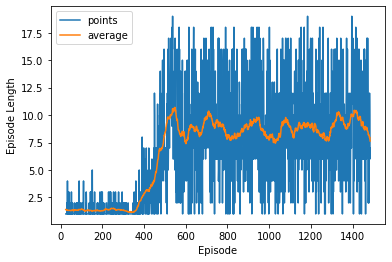

In [61]:
# Plot episodes lentghs during training
sl, pl = smooth_time_series(env.get_episode_lengths(), windows_size=50)
#env.get_episode_rewards()
#env.get_episode_lengths()
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR_NAME, "dqn_length_5x5_K_Inj_ET.png"), dpi=IMG_DPI)
plt.show()

In [62]:
# Play a game
play_single_game(model, env)

Row: 2 | Column: 2 | Value: 5
[[3 1 4 0 5]
 [0 5 2 4 0]
 [2 0 1 0 4]
 [5 4 3 1 2]
 [0 2 5 3 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 1 | Column: 4 | Value: 2
[[3 1 4 2 5]
 [0 5 2 4 0]
 [2 0 1 0 4]
 [5 4 3 1 2]
 [0 2 5 3 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 2 | Column: 1 | Value: 1
[[3 1 4 2 5]
 [1 5 2 4 0]
 [2 0 1 0 4]
 [5 4 3 1 2]
 [0 2 5 3 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 3 | Column: 2 | Value: 3
[[3 1 4 2 5]
 [1 5 2 4 0]
 [2 3 1 0 4]
 [5 4 3 1 2]
 [0 2 5 3 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: 5 | Column: 1 | Value: 4
[[3 1 4 2 5]
 [1 5 2 4 0]
 [2 3 1 0 4]
 [5 4 3 1 2]
 [4 2 5 3 1]]
feasibile: True

---------------------------

In [63]:
# Model Evaluation
evaluate_agent(model, dim)

MODEL EVALUATION WITH LATIN SQUARES 25.0% FILLED

Latin squares solved: 1.0%

Mean reward over 100 episodes: -0.98
Mean reward std 0.19899748742132398

Mean episode length over 100 episodes: 16.05
Mean episode length std 1.1608186766243902


MODEL EVALUATION WITH LATIN SQUARES 50.0% FILLED

Latin squares solved: 4.0%

Mean reward over 100 episodes: -0.92
Mean reward std 0.39191835884530846

Mean episode length over 100 episodes: 11.02
Mean episode length std 1.0768472500777444


MODEL EVALUATION WITH LATIN SQUARES 75.0% FILLED

Latin squares solved: 70.0%

Mean reward over 100 episodes: 0.4
Mean reward std 0.9165151389911679

Mean episode length over 100 episodes: 6.74
Mean episode length std 0.438634243989226


